In [1]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# import pickle
# import os
# import torch
# from torch import Tensor
# import numpy as np
# import time

# # import hydra
# # from omegaconf import DictConfig, OmegaConf
# # from hydra.utils import get_original_cwd, to_absolute_path

# # import logging

# from sbi.inference import MCMCPosterior
# from sbi.utils import mcmc_transform
# # from sbi.utils.metrics import c2st as C2ST

# # from pathlib import Path

# # # Algorithm imports.
# # from sbi.inference import SNPE, SNLE, likelihood_estimator_based_potential
# # from gbi.GBI import GBInference, GBInferenceEmulator
# import gbi.utils.utils as gbi_utils

# # # Task imports.
# from gbi.benchmark.tasks.uniform_1d.task import UniformNoise1D
# # from gbi.benchmark.tasks.two_moons.task import TwoMoonsGBI
# # from gbi.benchmark.tasks.linear_gaussian.task import LinearGaussian
# # from gbi.benchmark.tasks.gaussian_mixture.task import GaussianMixture
# from gbi import distances

# # import pandas as pd

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sbi.inference import MCMCPosterior
from sbi.utils import mcmc_transform
from sbi.inference.potentials.likelihood_based_potential import TemperedLikelihoodBasedPotential
from gbi.benchmark.tasks.uniform_1d.task import UniformNoise1D
import gbi.utils.utils as gbi_utils

/home/macke/rgao97/.conda/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
xos = gbi_utils.pickle_load('../gbi/benchmark/tasks/uniform_1d/xos/xo_specified_known.pkl')
task = UniformNoise1D()
# NLE = gbi_utils.pickle_load('../results/benchmark/algorithms/uniform_1d/2023_02_03__19_24_25/NLE/inference.pickle')

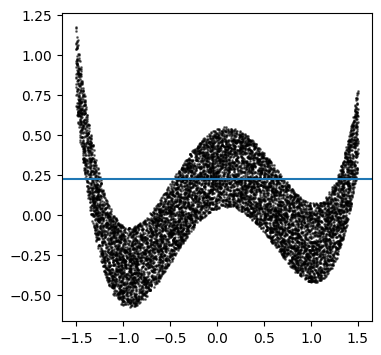

In [4]:
x_o = xos[4]
theta = task.prior.sample((10000,))
x = task.simulate(theta)
plt.figure(figsize=(4,4))
plt.plot( theta.numpy(), x.numpy(), 'k.', alpha=0.5, ms=2)
plt.axhline(x_o.numpy())

In [24]:
betas = [0.1, 1., 4., 20., 100.]
n_samples = 10000

posterior_samples = []
for beta in betas:
    potential_fn = TemperedLikelihoodBasedPotential(NLE._neural_net, task.prior, x_o, beta)
    theta_transform = mcmc_transform(task.prior)
    posterior = MCMCPosterior(
        potential_fn,
        theta_transform=theta_transform,
        proposal=task.prior,
        method="slice_np_vectorized",
        thin=10,
        warmup_steps=50,
        num_chains=100,
        init_strategy="resample",
        frac_chains_to_finish=0.9,
    )
    posterior_samples.append(posterior.sample((n_samples,)).numpy())
    

Running vectorized MCMC with 100 chains:   0%|          | 0/161200 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/161200 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/161200 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/161200 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/161200 [00:00<?, ?it/s]

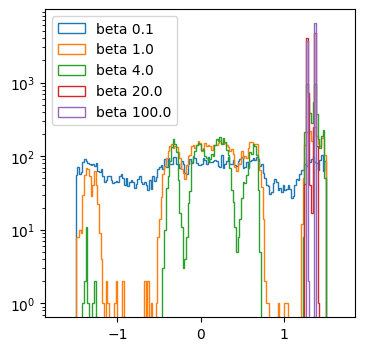

In [27]:
plt.figure(figsize=(4,4))
[plt.hist(ps, np.arange(-1.7,1.7,0.02), histtype='step', label=f'beta {betas[i_p]}', log=True) for i_p,ps in enumerate(posterior_samples)];
plt.legend(loc='upper left')

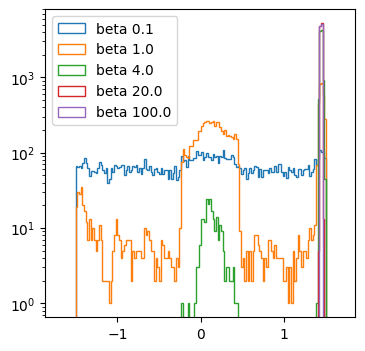

In [15]:
plt.figure(figsize=(4,4))
[plt.hist(ps, np.arange(-1.7,1.7,0.02), histtype='step', label=f'beta {betas[i_p]}', log=True) for i_p,ps in enumerate(posterior_samples)];
plt.legend(loc='upper left')

In [36]:
ACE = gbi_utils.pickle_load('../results/benchmark/algorithms/uniform_1d/2023_08_05__16_45_05/GBI/inference.pickle')


In [42]:
import torch
num_x_and_xt = 10000
random_inds_x = torch.randint(0, len(ACE.x), (num_x_and_xt,))
random_inds_xtarget = torch.randint(0, len(ACE.x_target), (num_x_and_xt,))
dist_subset = ACE.compute_distance(ACE.x[random_inds_x], ACE.x_target[random_inds_xtarget]).flatten().numpy()

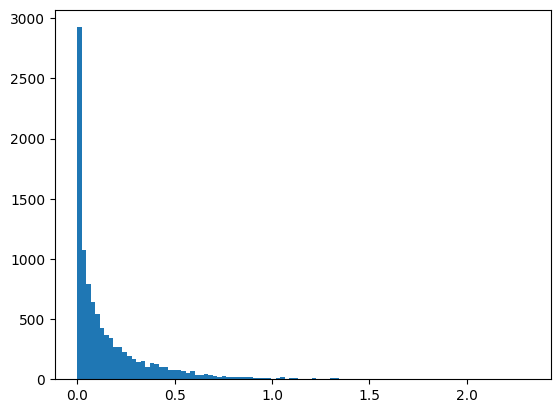

In [43]:
plt.hist(dist_subset,100);

In [47]:
prior_logprob = task.prior.log_prob(ACE.theta[random_inds_x]).numpy()

(-1.1475858092308044, -1.0986121)

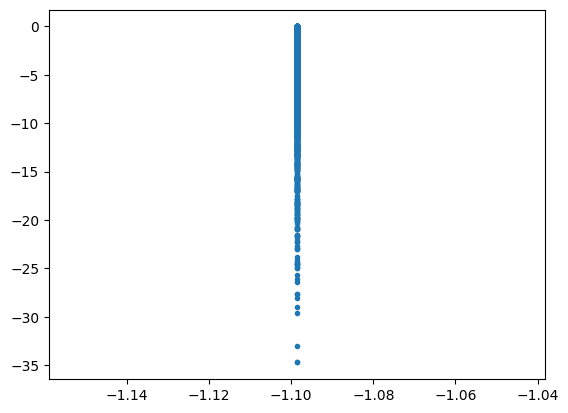

In [67]:
beta = 15
plt.plot(prior_logprob, beta * -dist_subset, '.')
-np.median(dist_subset)*beta, prior_logprob.mean()